# Scoring Pseudocode v1

Base zone: Standard Distance Circle (2 SDs) from Optimized Hot Spot Analysis of road segments using FHWA Crash Rates

- Component 1: Amount of fatal accidents within standard distance circle

- Component 2: Mean GI ZScore for features within the standard distance circle. 

- Component 3: Overlap with Standard Distance circles from Density-based Clustering of fatal accident points

    - If overlap:
           
        - Start with baseline overlap score value (e.g. 100)
        
        - If weight overlap by spatial distribution:
        
            - Get spatial distribution z-score (get all the mean standard distances for clustered FARS 
            
            - Subtract spatial distribution z-score from overlap score 
            (The greater the average spatial distribution, the lower overlap score value to be added to the zone)
            
        - Add overlap score value to overall score
        
#### Formula:

score = (component_1_val * component_1_weight) + (component_2_val * component_2_weight) + ((component_3_val - normalized_spatial_dist) * component_3_weight)

### Load Modules and Connect to GIS

In [1]:
import arcgis
import arcpy
import pandas as pd
import math
import seaborn

In [2]:
gis = arcgis.gis.GIS("https://esrifederal.maps.arcgis.com", username="Anieto_esrifederal")

Enter password: ········


## Test Sequence

##### Example:

- component_1_weight = 1
- component_2_weight = 0.75
- component_3_weight = 1.25
- weight_component_3_by_spatial_dist = True

Zone A:
- Accident Count = 3
- Mean GIZScore = 4.27
- Overlap = 1
- Mean Std. Distance = 0.00839

Zone B: 
- Accident Count = 1
- Mean GIZScore = 3.76
- Overlap = 0
- Mean Std. Distance = N/A

Zone C:
- Accident Count = 4
- Mean GIZScore = 4.54
- Overlap = 0
- Mean Std. Distance = N/A

Zone D: 
- Accident Count = 3
- Mean GIZScore = 3.71
- Overlap = 1
- Mean Std. Distance = 0.010048

In [3]:
component_1_weight = 1
component_2_weight = 0.75
component_3_weight = 1.25

In [4]:
sample_data = {
    "accident_count":[3, 1, 4, 3],
    "mean_gizscore": [4.27, 3.76, 4.54, 3.71],
    "overlap": [1, 0, 0, 1],
    "mean_std_dist": [0.00839, None, None, 0.010048]
}

sample_df = pd.DataFrame.from_dict(data=sample_data)
sample_df

,accident_count,mean_gizscore,overlap,mean_std_dist
0,3,4.27,1,0.008390
1,1,3.76,0,NaN
2,4,4.54,0,NaN
3,3,3.71,1,0.010048


In [5]:
def create_normalized_fields(df, list_of_fields):
    for field in list_of_fields:
        df[field+"_zscorecalc"] = (df[field] - df[field].mean())/df[field].std(ddof=0)
    return df

In [6]:
list_of_fields_to_normalize = [
    'accident_count',
    'mean_gizscore',
    'mean_std_dist'
]

sample_df = create_normalized_fields(sample_df, list_of_fields_to_normalize)
sample_df

,accident_count,mean_gizscore,overlap,mean_std_dist,accident_count_zscorecalc,mean_gizscore_zscorecalc,mean_std_dist_zscorecalc
0,3,4.27,1,0.008390,0.229416,0.573421,-1.0
1,1,3.76,0,NaN,-1.605910,-0.888803,NaN
2,4,4.54,0,NaN,1.147079,1.347540,NaN
3,3,3.71,1,0.010048,0.229416,-1.032159,1.0


In [7]:
def calculate_clustering_overlap_score(overlap_val, standard_distance_zscore_val, factor=100):
    if overlap_val == 0:
        overlap_score = 0
    else:
        overlap_score = (overlap_val * factor) - standard_distance_zscore_val
    return overlap_score

def translate_range_function(old_val, old_min, old_max, new_min, new_max):
    new_val = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    return new_val

def translate_range_in_df(dataframe, old_column, new_column_name, new_min, new_max):
    old_min = dataframe[old_column].min()
    old_max = dataframe[old_column].max()
    dataframe[new_column_name] = dataframe.apply(lambda x: translate_range_function(x[old_column], 
                                                                                    old_min, old_max, 
                                                                                    new_min, new_max), axis=1)
    return dataframe

In [8]:
sample_df['overlap_score'] = sample_df.apply(lambda x: calculate_clustering_overlap_score(x['overlap'], x['mean_std_dist_zscorecalc']), axis=1)
sample_df = translate_range_in_df(sample_df, 'accident_count_zscorecalc', 'accident_count_score', 0, 100)
sample_df = translate_range_in_df(sample_df, 'mean_gizscore_zscorecalc', 'hotspots_analysis_score', 0, 100)
sample_df

,accident_count,mean_gizscore,overlap,mean_std_dist,accident_count_zscorecalc,mean_gizscore_zscorecalc,mean_std_dist_zscorecalc,overlap_score,accident_count_score,hotspots_analysis_score
0,3,4.27,1,0.008390,0.229416,0.573421,-1.0,101.0,66.666667,67.469880
1,1,3.76,0,NaN,-1.605910,-0.888803,NaN,0.0,0.000000,6.024096
2,4,4.54,0,NaN,1.147079,1.347540,NaN,0.0,100.000000,100.000000
3,3,3.71,1,0.010048,0.229416,-1.032159,1.0,99.0,66.666667,0.000000


In [9]:
def calculate_overall_score(crash_count_score, ohs_score, overlap_score, 
                            crash_count_weight=component_1_weight, 
                            ohs_weight=component_2_weight,
                            overlap_weight=component_3_weight
                           ):
    score = float(float(crash_count_score) * crash_count_weight) + float(float(ohs_score) * ohs_weight) + float(float(overlap_score) * overlap_weight)
    return score

In [10]:
sample_df['overall_score'] = sample_df.apply(lambda x: calculate_overall_score(x['accident_count_score'], x['hotspots_analysis_score'], x['overlap_score']), axis=1)
sample_df

,accident_count,mean_gizscore,overlap,mean_std_dist,accident_count_zscorecalc,mean_gizscore_zscorecalc,mean_std_dist_zscorecalc,overlap_score,accident_count_score,hotspots_analysis_score,overall_score
0,3,4.27,1,0.008390,0.229416,0.573421,-1.0,101.0,66.666667,67.469880,243.519076
1,1,3.76,0,NaN,-1.605910,-0.888803,NaN,0.0,0.000000,6.024096,4.518072
2,4,4.54,0,NaN,1.147079,1.347540,NaN,0.0,100.000000,100.000000,175.000000
3,3,3.71,1,0.010048,0.229416,-1.032159,1.0,99.0,66.666667,0.000000,190.416667


# Full Sequence

### Helper Functions

In [11]:
def create_normalized_fields(df, list_of_fields):
    for field in list_of_fields:
        df[field+"_zscorecalc"] = (df[field] - df[field].mean())/df[field].std(ddof=0)
    return df

def calculate_clustering_overlap_score(overlap_val, standard_distance_zscore_val, factor=100):
    if overlap_val == 0:
        overlap_score = 0
    else:
        overlap_score = (overlap_val * factor) - standard_distance_zscore_val
    return overlap_score

def translate_range_function(old_val, old_min, old_max, new_min, new_max):
    new_val = (((old_val - old_min) * (new_max - new_min)) / (old_max - old_min)) + new_min
    return new_val

def translate_range_in_df(dataframe, old_column, new_column_name, new_min, new_max):
    old_min = dataframe[old_column].min()
    old_max = dataframe[old_column].max()
    dataframe[new_column_name] = dataframe.apply(lambda x: translate_range_function(x[old_column], 
                                                                                    old_min, old_max, 
                                                                                    new_min, new_max), axis=1)
    return dataframe

def calculate_overall_score(crash_count_score, ohs_score, overlap_score, 
                            crash_count_weight=component_1_weight, 
                            ohs_weight=component_2_weight,
                            overlap_weight=component_3_weight
                           ):
    score = float(float(crash_count_score) * crash_count_weight) + float(float(ohs_score) * ohs_weight) + float(float(overlap_score) * overlap_weight)
    return score

def process_overall_score(dataframe, accident_count_field, gizscore_field, overlap_field, standard_distance_field, score_field_name="overall_score"):

    # Create normalized ranges for each component
    df = create_normalized_fields(dataframe, [accident_count_field, gizscore_field, standard_distance_field])
    
    # Process each component score
    df['overlap_score'] = df.apply(lambda x: calculate_clustering_overlap_score(x[overlap_field], x[gizscore_field+'_zscorecalc']), axis=1)
    df = translate_range_in_df(df, accident_count_field+'_zscorecalc', 'accident_count_score', 0, 100)
    df = translate_range_in_df(df, gizscore_field+'_zscorecalc', 'hotspots_analysis_score', 0, 100)
    
    df[score_field_name] = df.apply(lambda x: calculate_overall_score(x['accident_count_score'], x['hotspots_analysis_score'], x['overlap_score']), axis=1)
    
    return df

### Load data

In [146]:
fc = "D:\\3_Sandbox_Projects\\1810_NHTSACrashAnalysis\\Work\\fatal_accidents_spatial_analysis\\fatal_accidents_spatial_analysis.gdb\\ZonesofConcernPostQC_SpatialJoin"
df = pd.DataFrame.spatial.from_featureclass(fc)
df.head()

,OBJECTID,Join_Count,TARGET_FID,CenterX,CenterY,StdDist,CLUSTER_ID,Point_Count,SUM_Crash_Rate_FHWA,MEAN_Crash_Rate_FHWA,...,Minority_CLUSTER_ID_Percent,Majority_CLUSTER_ID_Percent,Join_ID_1,OHS_DBSCAN_Overlap,STATE_NAME,STATE_FIPS,SUB_REGION,STATE_ABBR,NHTSA_REGION,SHAPE
0,1,1,1,-97.774492,26.521082,0.005603,1,6,0.000000,0.000000,...,NaN,NaN,1,0,Texas,48,West South Central,TX,6,"{""rings"": [[[-97.76892089828021, 26.5214843749..."
1,2,1,2,-97.779818,26.440334,0.049997,2,54,295.049461,5.463879,...,NaN,NaN,2,0,Texas,48,West South Central,TX,6,"{""rings"": [[[-97.72979736305723, 26.4395141597..."
2,3,1,3,-101.576489,35.219861,0.045435,3,45,339.623780,7.547195,...,NaN,NaN,3,0,Texas,48,West South Central,TX,6,"{""rings"": [[[-101.53100585903258, 35.220703124..."
3,4,1,4,-122.568204,41.866117,0.058215,4,64,296.507146,4.632924,...,NaN,NaN,4,0,California,06,Pacific,CA,9,"{""rings"": [[[-122.5100097652379, 41.8660888670..."
4,5,1,5,-109.423063,41.526812,0.018711,5,17,406.207294,23.894547,...,NaN,NaN,5,0,Wyoming,56,Mountain,WY,8,"{""rings"": [[[-109.4042968751001, 41.5258789063..."


In [147]:
df.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'CenterX', 'CenterY', 'StdDist',
       'CLUSTER_ID', 'Point_Count', 'SUM_Crash_Rate_FHWA',
       'MEAN_Crash_Rate_FHWA', 'SUM_GiZScore', 'MEAN_GiZScore', 'SUM_Gi_Bin',
       'MEAN_Gi_Bin', 'fatal_accident_count', 'Minority_HARM_EV',
       'Majority_HARM_EV', 'Minority_HARM_EV_Percent',
       'Majority_HARM_EV_Percent', 'Join_ID', 'SUM_Area_SQUAREFEET',
       'SUM_StdDist', 'MIN_StdDist', 'MAX_StdDist', 'MEAN_StdDist',
       'Minority_CLUSTER_ID', 'Majority_CLUSTER_ID',
       'Minority_CLUSTER_ID_Percent', 'Majority_CLUSTER_ID_Percent',
       'Join_ID_1', 'OHS_DBSCAN_Overlap', 'STATE_NAME', 'STATE_FIPS',
       'SUB_REGION', 'STATE_ABBR', 'NHTSA_REGION', 'SHAPE'],
      dtype='object')

In [149]:
# Calculate zeroes for zones where FARS locations were outside of Standard Distance circle
df.fatal_accident_count.fillna(0, inplace=True)

### Process dataframe inputs and calculate overall score

In [150]:
component_1_weight = 1
component_2_weight = 0.75
component_3_weight = 1.25

In [151]:
accident_count_field = 'fatal_accident_count'
gizscore_field = 'MEAN_GiZScore'
overlap_field = 'OHS_DBSCAN_Overlap'
standard_distance_field = 'MEAN_StdDist'

### Calculate Weighted Score for Each Zone Nationally

In [166]:
national_df = process_overall_score(df, 
                                 accident_count_field, 
                                 gizscore_field, 
                                 overlap_field, 
                                 standard_distance_field, 
                                 score_field_name="overall_score_national")
national_df.overall_score_national.describe()

count    624.000000
mean      27.845404
std       33.157201
min        0.425722
25%       13.836510
50%       18.764459
75%       28.318963
max      239.600521
Name: overall_score_national, dtype: float64

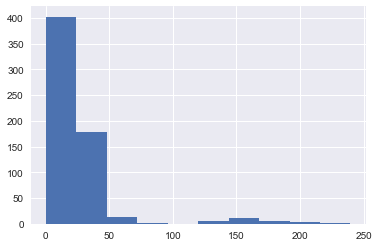

In [167]:
national_df.overall_score_national.hist()

In [168]:
national_df.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'CenterX', 'CenterY', 'StdDist',
       'CLUSTER_ID', 'Point_Count', 'SUM_Crash_Rate_FHWA',
       'MEAN_Crash_Rate_FHWA', 'SUM_GiZScore', 'MEAN_GiZScore', 'SUM_Gi_Bin',
       'MEAN_Gi_Bin', 'fatal_accident_count', 'Minority_HARM_EV',
       'Majority_HARM_EV', 'Minority_HARM_EV_Percent',
       'Majority_HARM_EV_Percent', 'Join_ID', 'SUM_Area_SQUAREFEET',
       'SUM_StdDist', 'MIN_StdDist', 'MAX_StdDist', 'MEAN_StdDist',
       'Minority_CLUSTER_ID', 'Majority_CLUSTER_ID',
       'Minority_CLUSTER_ID_Percent', 'Majority_CLUSTER_ID_Percent',
       'Join_ID_1', 'OHS_DBSCAN_Overlap', 'STATE_NAME', 'STATE_FIPS',
       'SUB_REGION', 'STATE_ABBR', 'NHTSA_REGION', 'SHAPE',
       'fatal_accident_count_zscorecalc', 'MEAN_GiZScore_zscorecalc',
       'MEAN_StdDist_zscorecalc', 'overlap_score', 'accident_count_score',
       'hotspots_analysis_score', 'overall_score_national'],
      dtype='object')

In [169]:
national_df = national_df.rename(columns = {
    'fatal_accident_count_zscorecalc':'national_accident_count_zscore',
    'MEAN_GiZScore_zscorecalc':'national_mean_ohsgi_zscore',
    'MEAN_StdDist_zscorecalc':'national_mean_stddist_zscore',
})

In [171]:
national_df.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'CenterX', 'CenterY', 'StdDist',
       'CLUSTER_ID', 'Point_Count', 'SUM_Crash_Rate_FHWA',
       'MEAN_Crash_Rate_FHWA', 'SUM_GiZScore', 'MEAN_GiZScore', 'SUM_Gi_Bin',
       'MEAN_Gi_Bin', 'fatal_accident_count', 'Minority_HARM_EV',
       'Majority_HARM_EV', 'Minority_HARM_EV_Percent',
       'Majority_HARM_EV_Percent', 'Join_ID', 'SUM_Area_SQUAREFEET',
       'SUM_StdDist', 'MIN_StdDist', 'MAX_StdDist', 'MEAN_StdDist',
       'Minority_CLUSTER_ID', 'Majority_CLUSTER_ID',
       'Minority_CLUSTER_ID_Percent', 'Majority_CLUSTER_ID_Percent',
       'Join_ID_1', 'OHS_DBSCAN_Overlap', 'STATE_NAME', 'STATE_FIPS',
       'SUB_REGION', 'STATE_ABBR', 'NHTSA_REGION', 'SHAPE',
       'national_accident_count_zscore', 'national_mean_ohsgi_zscore',
       'national_mean_stddist_zscore', 'overlap_score', 'accident_count_score',
       'hotspots_analysis_score', 'overall_score_national', 'national_rank'],
      dtype='object')

In [172]:
national_df['national_rank'] = national_df['overall_score_national'].rank(ascending=False)

### Calculate Weighted Score for Each Zone Regionally

In [173]:
national_df.NHTSA_REGION.unique().tolist()

['6', '9', '8', '4', '10', '7', '5', '3', '1', '2']

In [174]:
dfs_container = []
for nhtsa_region in national_df['NHTSA_REGION'].unique().tolist():
    region_df = national_df.loc[df['NHTSA_REGION'] == nhtsa_region]
    region_df = process_overall_score(region_df, 
                                      accident_count_field, 
                                      gizscore_field, 
                                      overlap_field, 
                                      standard_distance_field, 
                                      score_field_name="overall_score_regional")
    dfs_container.append(region_df)
regional_df = pd.concat(dfs_container)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [175]:
regional_df.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'CenterX', 'CenterY', 'StdDist',
       'CLUSTER_ID', 'Point_Count', 'SUM_Crash_Rate_FHWA',
       'MEAN_Crash_Rate_FHWA', 'SUM_GiZScore', 'MEAN_GiZScore', 'SUM_Gi_Bin',
       'MEAN_Gi_Bin', 'fatal_accident_count', 'Minority_HARM_EV',
       'Majority_HARM_EV', 'Minority_HARM_EV_Percent',
       'Majority_HARM_EV_Percent', 'Join_ID', 'SUM_Area_SQUAREFEET',
       'SUM_StdDist', 'MIN_StdDist', 'MAX_StdDist', 'MEAN_StdDist',
       'Minority_CLUSTER_ID', 'Majority_CLUSTER_ID',
       'Minority_CLUSTER_ID_Percent', 'Majority_CLUSTER_ID_Percent',
       'Join_ID_1', 'OHS_DBSCAN_Overlap', 'STATE_NAME', 'STATE_FIPS',
       'SUB_REGION', 'STATE_ABBR', 'NHTSA_REGION', 'SHAPE',
       'national_accident_count_zscore', 'national_mean_ohsgi_zscore',
       'national_mean_stddist_zscore', 'overlap_score', 'accident_count_score',
       'hotspots_analysis_score', 'overall_score_national', 'national_rank',
       'fatal_accident_count_zscorecalc', 'ME

In [176]:
regional_df = regional_df.rename(columns = {
    'fatal_accident_count_zscorecalc':'regional_accident_count_zscore',
    'MEAN_GiZScore_zscorecalc':'regional_mean_ohsgi_zscore',
    'MEAN_StdDist_zscorecalc':'regional_mean_stddist_zscore',
})

In [177]:
regional_df.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'CenterX', 'CenterY', 'StdDist',
       'CLUSTER_ID', 'Point_Count', 'SUM_Crash_Rate_FHWA',
       'MEAN_Crash_Rate_FHWA', 'SUM_GiZScore', 'MEAN_GiZScore', 'SUM_Gi_Bin',
       'MEAN_Gi_Bin', 'fatal_accident_count', 'Minority_HARM_EV',
       'Majority_HARM_EV', 'Minority_HARM_EV_Percent',
       'Majority_HARM_EV_Percent', 'Join_ID', 'SUM_Area_SQUAREFEET',
       'SUM_StdDist', 'MIN_StdDist', 'MAX_StdDist', 'MEAN_StdDist',
       'Minority_CLUSTER_ID', 'Majority_CLUSTER_ID',
       'Minority_CLUSTER_ID_Percent', 'Majority_CLUSTER_ID_Percent',
       'Join_ID_1', 'OHS_DBSCAN_Overlap', 'STATE_NAME', 'STATE_FIPS',
       'SUB_REGION', 'STATE_ABBR', 'NHTSA_REGION', 'SHAPE',
       'national_accident_count_zscore', 'national_mean_ohsgi_zscore',
       'national_mean_stddist_zscore', 'overlap_score', 'accident_count_score',
       'hotspots_analysis_score', 'overall_score_national', 'national_rank',
       'regional_accident_count_zscore', 'reg

In [178]:
regional_df['region_rank'] = regional_df.groupby('NHTSA_REGION')["overall_score_regional"].rank(ascending=False)

### Calculate Weighted Score for Each Zone by State

In [179]:
dfs_container = []

for state in regional_df['STATE_ABBR'].unique().tolist():
    print("Processing "+state+"...")
    state_df = regional_df.loc[df['STATE_ABBR'] == state]
    state_df = process_overall_score(state_df, 
                                     accident_count_field, 
                                     gizscore_field, 
                                     overlap_field, 
                                     standard_distance_field, 
                                     score_field_name="overall_score_state")
    dfs_container.append(state_df)

states_df = pd.concat(dfs_container)    

Processing TX...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Processing NM...
Processing OK...
Processing LA...
Processing MS...
Processing CA...
Processing AZ...
Processing WY...
Processing NV...
Processing UT...
Processing ND...
Processing SD...
Processing CO...
Processing FL...
Processing GA...
Processing SC...
Processing AL...
Processing TN...
Processing ID...
Processing MT...
Processing OR...
Processing WA...
Processing IA...
Processing KS...
Processing MO...
Processing AR...
Processing NE...
Processing MI...
Processing OH...
Processing IL...
Processing MN...
Processing WI...
Processing IN...
Processing KY...
Processing VA...
Processing NC...
Processing WV...
Processing MD...
Processing ME...
Processing NH...
Processing VT...
Processing MA...
Processing RI...
Processing NY...
Processing CT...
Processing PA...
Processing NJ...


In [180]:
states_df.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'CenterX', 'CenterY', 'StdDist',
       'CLUSTER_ID', 'Point_Count', 'SUM_Crash_Rate_FHWA',
       'MEAN_Crash_Rate_FHWA', 'SUM_GiZScore', 'MEAN_GiZScore', 'SUM_Gi_Bin',
       'MEAN_Gi_Bin', 'fatal_accident_count', 'Minority_HARM_EV',
       'Majority_HARM_EV', 'Minority_HARM_EV_Percent',
       'Majority_HARM_EV_Percent', 'Join_ID', 'SUM_Area_SQUAREFEET',
       'SUM_StdDist', 'MIN_StdDist', 'MAX_StdDist', 'MEAN_StdDist',
       'Minority_CLUSTER_ID', 'Majority_CLUSTER_ID',
       'Minority_CLUSTER_ID_Percent', 'Majority_CLUSTER_ID_Percent',
       'Join_ID_1', 'OHS_DBSCAN_Overlap', 'STATE_NAME', 'STATE_FIPS',
       'SUB_REGION', 'STATE_ABBR', 'NHTSA_REGION', 'SHAPE',
       'national_accident_count_zscore', 'national_mean_ohsgi_zscore',
       'national_mean_stddist_zscore', 'overlap_score', 'accident_count_score',
       'hotspots_analysis_score', 'overall_score_national', 'national_rank',
       'regional_accident_count_zscore', 'reg

In [181]:
states_df = states_df.rename(columns = {
    'fatal_accident_count_zscorecalc':'state_accident_count_zscore',
    'MEAN_GiZScore_zscorecalc':'state_mean_ohsgi_zscore',
    'MEAN_StdDist_zscorecalc':'state_mean_stddist_zscore',
})

In [182]:
states_df.columns

Index(['OBJECTID', 'Join_Count', 'TARGET_FID', 'CenterX', 'CenterY', 'StdDist',
       'CLUSTER_ID', 'Point_Count', 'SUM_Crash_Rate_FHWA',
       'MEAN_Crash_Rate_FHWA', 'SUM_GiZScore', 'MEAN_GiZScore', 'SUM_Gi_Bin',
       'MEAN_Gi_Bin', 'fatal_accident_count', 'Minority_HARM_EV',
       'Majority_HARM_EV', 'Minority_HARM_EV_Percent',
       'Majority_HARM_EV_Percent', 'Join_ID', 'SUM_Area_SQUAREFEET',
       'SUM_StdDist', 'MIN_StdDist', 'MAX_StdDist', 'MEAN_StdDist',
       'Minority_CLUSTER_ID', 'Majority_CLUSTER_ID',
       'Minority_CLUSTER_ID_Percent', 'Majority_CLUSTER_ID_Percent',
       'Join_ID_1', 'OHS_DBSCAN_Overlap', 'STATE_NAME', 'STATE_FIPS',
       'SUB_REGION', 'STATE_ABBR', 'NHTSA_REGION', 'SHAPE',
       'national_accident_count_zscore', 'national_mean_ohsgi_zscore',
       'national_mean_stddist_zscore', 'overlap_score', 'accident_count_score',
       'hotspots_analysis_score', 'overall_score_national', 'national_rank',
       'regional_accident_count_zscore', 'reg

In [183]:
states_df['state_rank'] = states_df.groupby('STATE_ABBR')["overall_score_state"].rank(ascending=False)

### Write back to Feature Class or Publish to GIS

In [184]:
final_df = states_df[["OBJECTID", 
                      'overlap_score', 'accident_count_score', 'hotspots_analysis_score', 
                      'national_accident_count_zscore', 'national_mean_ohsgi_zscore', 'national_mean_stddist_zscore',  
                      'regional_accident_count_zscore', 'regional_mean_ohsgi_zscore', 'regional_mean_stddist_zscore', 
                      'state_accident_count_zscore', 'state_mean_ohsgi_zscore', 'state_mean_stddist_zscore',  
                      'overall_score_national', 'overall_score_regional', 'overall_score_state', 
                      'national_rank', 'region_rank', 'state_rank',]]
final_df

,OBJECTID,overlap_score,accident_count_score,hotspots_analysis_score,national_accident_count_zscore,national_mean_ohsgi_zscore,national_mean_stddist_zscore,regional_accident_count_zscore,regional_mean_ohsgi_zscore,regional_mean_stddist_zscore,state_accident_count_zscore,state_mean_ohsgi_zscore,state_mean_stddist_zscore,overall_score_national,overall_score_regional,overall_score_state,national_rank,region_rank,state_rank
0,1,0.000000,0.000000,5.149588,-1.504654,-0.776011,NaN,-1.574802,-0.819494,NaN,-1.252609,-0.875939,NaN,1.704750,3.508020,3.862191,617.0,86.0,16.0
1,2,0.000000,50.000000,19.501315,0.881379,-0.536778,NaN,0.635001,-0.497684,NaN,0.215967,-0.327034,NaN,25.874342,57.657728,64.625986,203.0,32.0,10.0
2,3,0.000000,50.000000,8.017418,0.881379,-0.728207,NaN,0.635001,-0.755188,NaN,0.215967,-0.766255,NaN,24.316105,54.337234,56.013064,223.0,35.0,11.0
13,14,0.000000,0.000000,48.215225,-1.504654,-0.058137,NaN,-1.574802,0.146169,NaN,-1.252609,0.771176,NaN,7.548278,15.960167,36.161419,581.0,81.0,13.0
14,15,0.000000,0.000000,4.358927,-1.504654,-0.789191,NaN,-1.574802,-0.837223,NaN,-1.252609,-0.906179,NaN,1.597466,3.279405,3.269196,618.0,87.0,17.0
29,30,100.660062,100.000000,10.793929,3.267412,-0.681924,1.110247,2.844803,-0.692931,1.022282,1.684543,-0.660062,1.0,172.767474,231.006207,233.920525,10.0,2.0,1.0
38,39,0.000000,50.000000,23.941273,0.881379,-0.462767,NaN,0.635001,-0.398127,NaN,0.215967,-0.157221,NaN,26.476795,58.941512,67.955955,193.0,30.0,9.0
63,64,0.000000,0.000000,11.012308,-1.504654,-0.678284,NaN,-1.574802,-0.688034,NaN,-1.252609,-0.651710,NaN,2.500256,5.203187,8.259231,611.0,85.0,15.0
64,65,0.000000,0.000000,100.000000,-1.504654,0.805081,NaN,-1.574802,1.307341,NaN,-1.252609,2.751768,NaN,14.574895,30.933395,75.000000,440.0,66.0,7.0
75,76,0.000000,25.000000,19.548547,-0.311637,-0.535991,NaN,-0.469900,-0.496625,NaN,-0.518321,-0.325228,NaN,14.769640,32.671384,39.661410,433.0,62.0,12.0


In [185]:
final_df.to_csv(r"C:\Users\albe9057\Documents\GitHub\traffic_accidents_spatial_analysis\src\nhtsa_analysis\processed_zones_final.csv")